## 9.9 Seasonal ARIMA models
ARIMA models are also capable of modelling a wide range of seasonal data.

A seasonal ARIMA model is formed by including additional seasonal terms in the ARIMA models we have seen so far. It is written as follows:
$$
\text{ARIMA} \quad
\underbrace{(p, d, q)}_{\text{Non-seasonal part of the model}}
\quad
\underbrace{(P, D, Q)_m}_{\text{Seasonal part of the model}}
$$
where $m=$ the seasonal period (e.g. number of observations per year). We use uppercase notation for the seasonal parts of the model, and lowercase notation for the non-seasonal parts of the model.

The seasonal part of the model consists of terms that are similar to the non-seasonal components of the model, but involve backshifts of the seasonal period. For example, an $\text{ARIMA}(1,1,1)(1,1,1)_4$ model (without a constant) is for quarterly data ($m=4$), and can be written as
$$
(1-\phi_1B)(1-\Phi_1B^4)(1-B)(1-B^4)y_t = (1+\theta_1B)(1+\Theta_1B^4)\varepsilon_t.
$$
The additional seasonal terms are simply multiplied by the non-seasonal terms.

### ACF/PACF
The seasonal part of an AR or MA model will be seen in the seasonal lags of the PACF and ACF. For example, an $\text{ARIMA}(0,0,0)(0,0,1)_{12}$ model will show:
- a spike at lag 12 in the ACF but no other significant spike;
- exponential decay in the seasonal lags of the PACF (i.e. at lags 12, 24, 36,...)

Similarly, an $\text{ARIMA}(0,0,0)(1,0,0)_{12}$ model will show:
- exponential decay in the seasonal lags of the ACF;
- a single significant spike at lag 12 in the PACF.

In considering the appropriate seasonal orders for a seasonal ARIMA model, restrict attention to the seasonal lags.

The modelling procedure is almost the same as for non-seasonal data, except that we need to select seasonal AR and MA terms as well as the non-seasonal components of the model. The process is best illustrated via examples.

### Example: Monthly US leisure and hospitality employment
We will describe seasonal ARIMA modelling using monthly US employment data for leisure and hospitality jobs from January 2001 to September 2019.

In [1]:
import sys
sys.path.append('..')
from utils import *
from get_data import us_employment

In [6]:
leisure = (
    us_employment.query(
        'Title=="Leisure and Hospitality" and Month > "2000-01-01"'
    ).assign(Employed=us_employment["Employed"] / 1000.0)
    .set_index('Month')
)

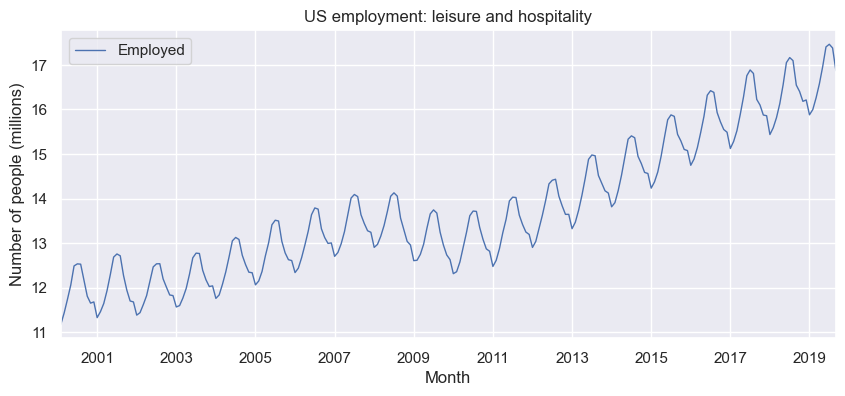

In [11]:
f, ax = plt.subplots(figsize=(10, 4))
leisure.plot(ax=ax)
ax.set(title='US employment: leisure and hospitality', ylabel='Number of people (millions)');

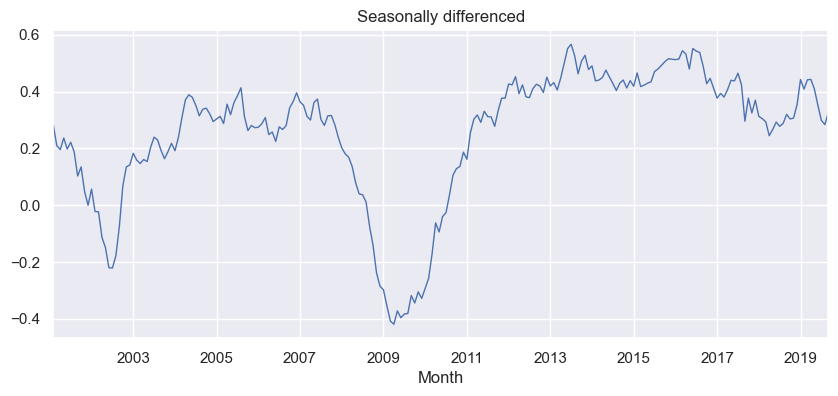

In [17]:
leisure['Employed'].diff(12).dropna().plot(title='Seasonally differenced', figsize=(10, 4));

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

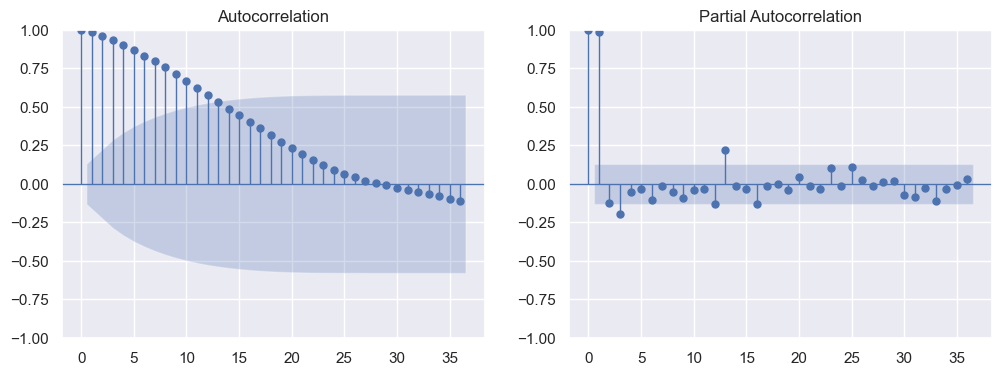

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(leisure['Employed'].diff(12).dropna(), ax=axes[0], lags=36)
plot_pacf(leisure['Employed'].diff(12).dropna(), ax=axes[1], lags=36);

The seasonally differenced values are clearly non-stationary, so we take a further first difference.

In [25]:
double_diff = leisure['Employed'].diff(12).diff().dropna()

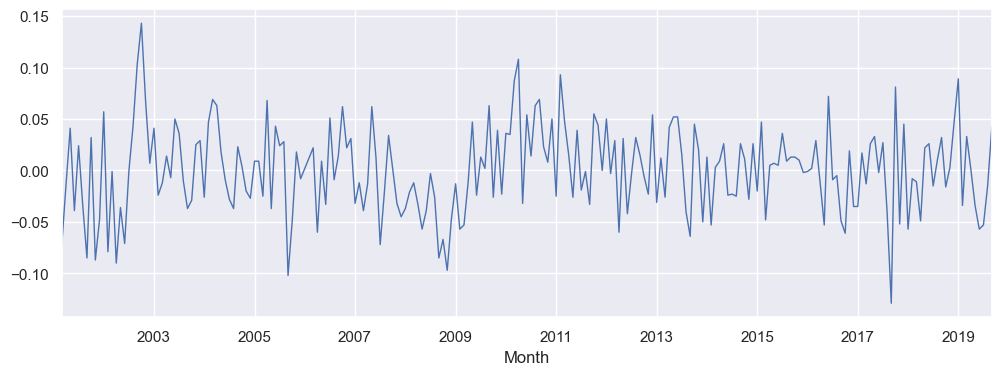

In [32]:
double_diff.plot(figsize=(12,4));

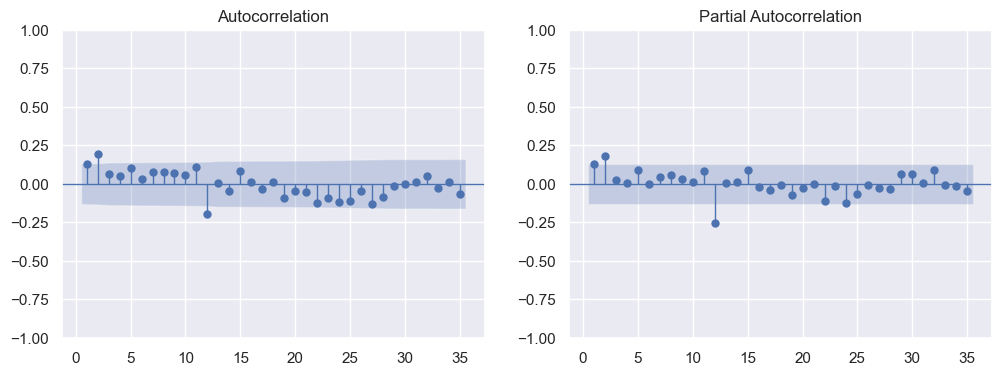

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(double_diff, ax=axes[0], lags=np.r_[1:36])
plot_pacf(double_diff, ax=axes[1], lags=np.r_[1:36]);

We want to find an appropriate ARIMA model based on the ACF and PACF show in the above figures. The significant spike at lag 2 in the ACF suggests a non-seasonal MA(2) component. The significant spike at lag 12 in the ACF suggests a seasonal MA(1) component. Consequently, we begin with an $\text{ARIMA}(0,1,2)(0,1,1)_{12}$ model, indicating a first difference, a seasonal difference and non-seasonal MA(2) and seasonal MA(1) component.

#### AutoARIMA using `statsforecast`
Use the `statsforecast` library to fit an ARIMA model to the data.

In [34]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.arima import arima_string

In [35]:
season_length = 12 # Monthly data
models = [AutoARIMA(season_length=season_length)]

In [55]:
df = leisure.reset_index()[['Month', 'Employed']]
df['unique_id'] = 1
df.columns = ['ds', 'y', 'unique_id']

In [ ]:
sf = StatsForecast(df=df, models=models, freq='MS', n_jobs=-1)
sf.fit()

In [42]:
arima_string(sf.fitted_[0, 0].model_)

'ARIMA(1,1,1)(0,1,2)[12]                   '

The automation process gave us that the best model found is a model of the form `ARIMA(1,1,1)(0,1,2)[12]`. 

In [43]:
results = sf.fitted_[0, 0].model_

In [44]:
residual = pd.DataFrame(results.get('residuals'), columns=['residual'])

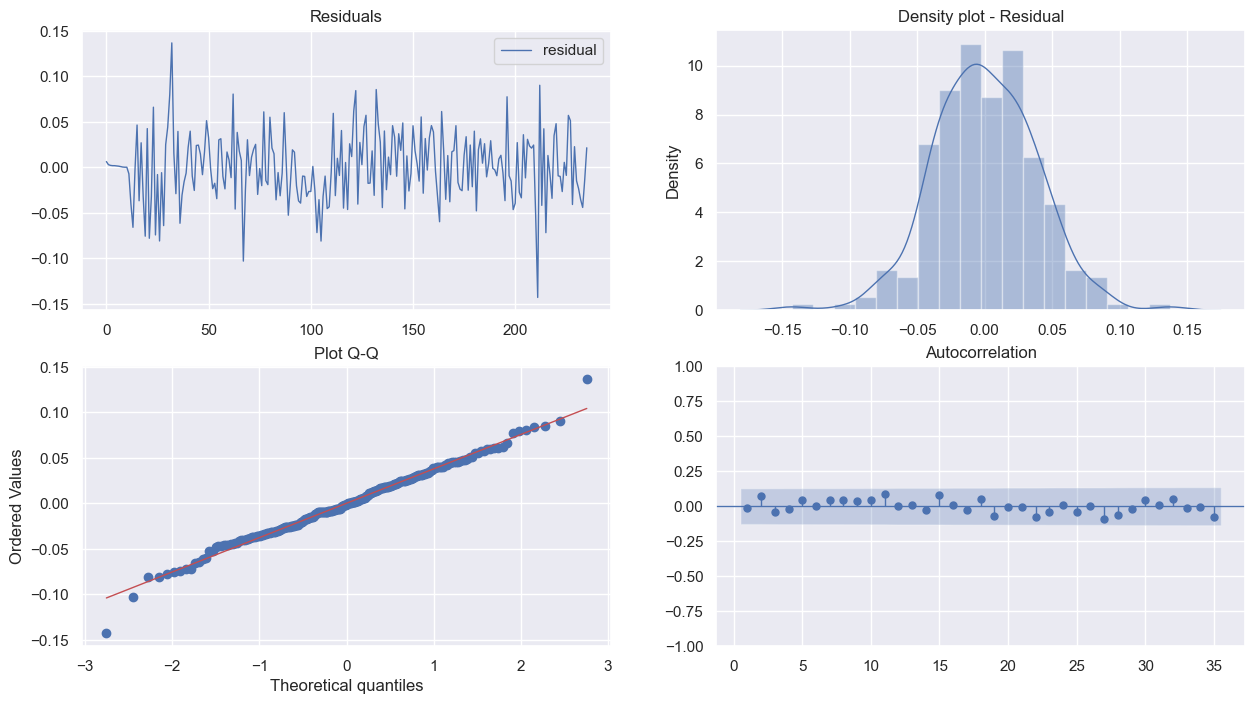

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))
residual.plot(ax=axs[0,0])
axs[0,0].set_title("Residuals");

sns.distplot(residual, ax=axs[0,1]);
axs[0,1].set_title("Density plot - Residual");

stats.probplot(residual["residual"], dist="norm", plot=axs[1,0])
axs[1,0].set_title('Plot Q-Q')

plot_acf(residual,  lags=np.r_[1:36], ax=axs[1,1])
axs[1,1].set_title("Autocorrelation");

plt.show();

In [60]:
Y_hat_df = sf.forecast(h=36, fitted=True).reset_index()

In [64]:
plot_df = pd.concat([df, Y_hat_df]).set_index('ds')

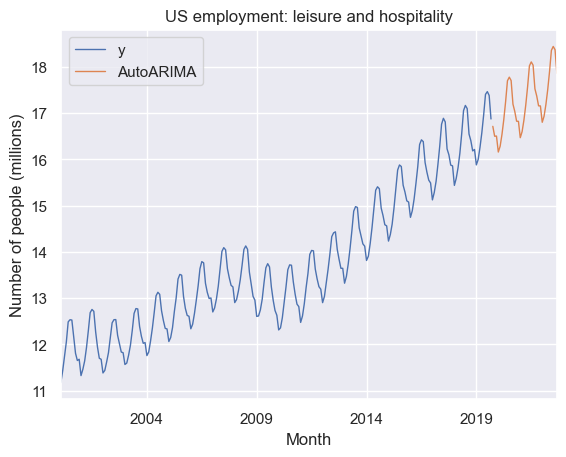

In [83]:
fig, ax = plt.subplots()
plot_df[['y', 'AutoARIMA']].plot(ax=ax, linewidth=1)
ax.set(title='US employment: leisure and hospitality', xlabel='Month', ylabel="Number of people (millions)");

In [70]:
forecast_df = sf.predict(h=36, level = [80, 95]) 

In [73]:
df_plot = pd.concat([df, forecast_df]).set_index('ds')

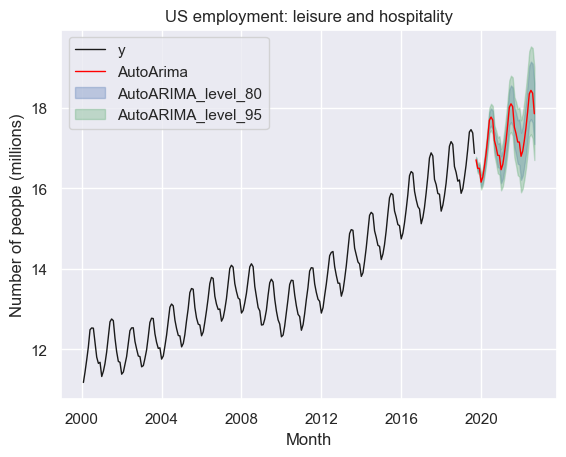

In [ ]:
fig, ax = plt.subplots()

plt.plot(df_plot["y"], "k-", linewidth=1, label="y")
plt.plot(df_plot["AutoARIMA"], "b-", color="red", linewidth=1, label="AutoArima")

# Specify graph features:
ax.fill_between(
    df_plot.index,
    df_plot["AutoARIMA-lo-80"],
    df_plot["AutoARIMA-hi-80"],
    alpha=0.3,
    color="b",
    label="AutoARIMA_level_80",
)
ax.fill_between(
    df_plot.index,
    df_plot["AutoARIMA-lo-95"],
    df_plot["AutoARIMA-hi-95"],
    alpha=0.3,
    color="g",
    label="AutoARIMA_level_95",
)
ax.set_title("US employment: leisure and hospitality")
ax.set_ylabel("Number of people (millions)")
ax.set_xlabel("Month")
ax.legend()
ax.grid(True)
plt.show()
